# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

2023-09-10 15:10:01.812594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 15:10:02.468381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")

metadata.file = metadata.file.str.replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/")

CPU times: user 1.79 s, sys: 189 ms, total: 1.98 s
Wall time: 1.99 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/projects/site/pred/data_science/year/2022/imm...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/projects/site/pred/data_science/year/2022/imm...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


lets plot a random image per class

B_T_cell_in_one_layer
B_cell
Multiplets
No_cell_cell_interaction
Synapses_with_signaling
Synapses_without_signaling
T_cell
T_cell_with_B_cell_fragments
T_cell_with_signaling


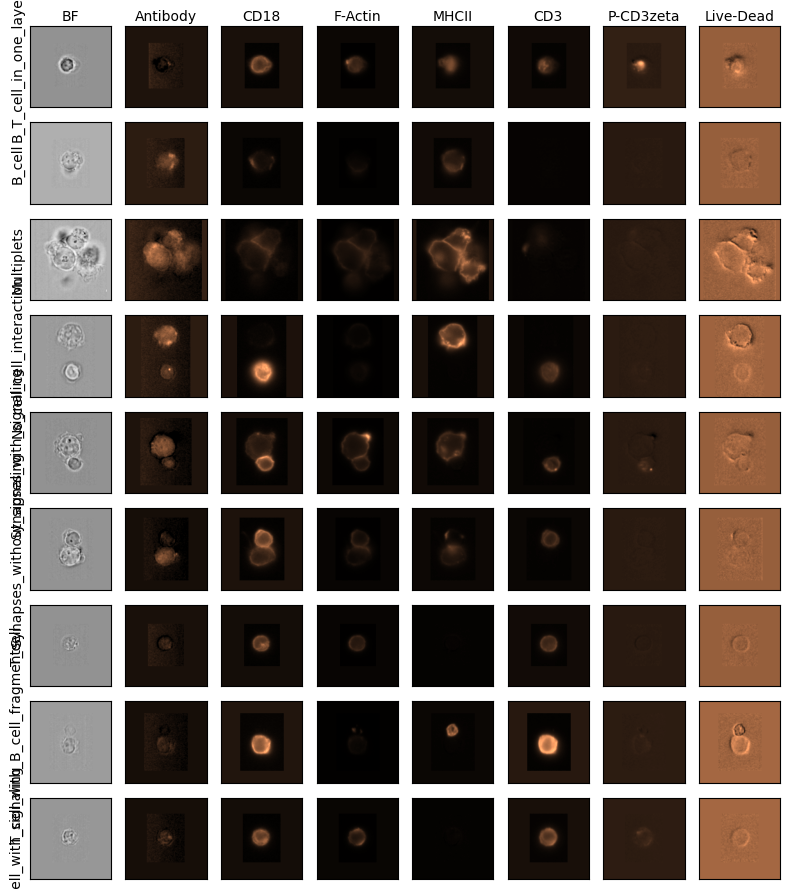

In [7]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 3)).reset_index(drop = True) ,  
                              figsize = (8,len(metadata.label.unique())),
                          channels = ["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper", "copper", "copper"],
                    image_size = 128)


Set all random seeds to the specific value, so the results are more reproducable

Define all necessary parameters

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [9]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [10]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160
num_classes = len(metadata.label.unique())

In [11]:

channels = np.asarray(["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"])
selected_channels = np.arange(len(channels))
num_channels = len(selected_channels)
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [12]:
selected_channels

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
batch_size = 128
num_workers = 4
device="cuda"

In [14]:
label_map = dict(zip(sorted(set(metadata.loc[:, "label"])), 
                     np.arange(len(set(metadata.loc[:, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'B_T_cell_in_one_layer': 0,
 'B_cell': 1,
 'Multiplets': 2,
 'No_cell_cell_interaction': 3,
 'Synapses_with_signaling': 4,
 'Synapses_without_signaling': 5,
 'T_cell': 6,
 'T_cell_with_B_cell_fragments': 7,
 'T_cell_with_signaling': 8}

splitting data to train, validaiton and test

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

seed_value = 42
train_index, _, _, _ = train_test_split(metadata.index, 
                                                    metadata.label.tolist(), 
                                                    stratify = metadata.label.tolist(),
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=seed_value)


skf = StratifiedKFold(n_splits=5,shuffle=False)
main_fold = 5

i = 1
for train_index, test_index in skf.split(train_index.tolist(), 
                                metadata.loc[train_index, "label"].replace(label_map)):
    if i == main_fold:
        break
    else:
        i+=1




train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [16]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([]))

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

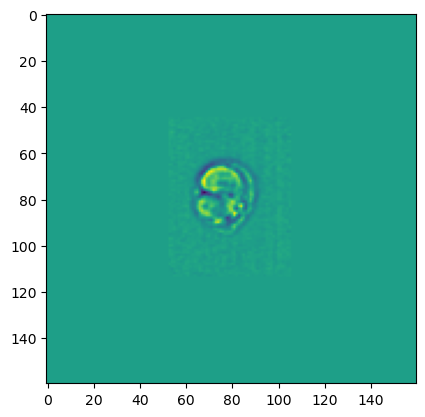

In [18]:
plt.imshow(train_dataset[0][0][0])

In [19]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 21/21 [02:07<00:00,  6.06s/it]

statistics used: {'min': tensor([7.0179e-02, 0.0000e+00, 2.9188e-03, 4.1281e-03, 3.3723e-04, 5.6747e-03,
        0.0000e+00, 5.8143e-05]), 'p01': tensor([0.1798, 0.0000, 0.0098, 0.0066, 0.0085, 0.0118, 0.0087, 0.0081]), 'p05': tensor([0.1872, 0.0005, 0.0103, 0.0071, 0.0090, 0.0122, 0.0090, 0.0085]), 'p25': tensor([0.1898, 0.0011, 0.0128, 0.0128, 0.0093, 0.0137, 0.0093, 0.0086]), 'p50': tensor([0.1948, 0.0017, 0.0155, 0.0169, 0.0125, 0.0187, 0.0095, 0.0088]), 'p75': tensor([0.1986, 0.0021, 0.0183, 0.0229, 0.0174, 0.0236, 0.0097, 0.0089]), 'p95': tensor([0.1996, 0.0029, 0.0253, 0.0470, 0.0286, 0.0325, 0.0101, 0.0092]), 'p99': tensor([0.2073, 0.0058, 0.0493, 0.0961, 0.0568, 0.0706, 0.0108, 0.0101]), 'max': tensor([0.3406, 0.0347, 0.2550, 0.9475, 0.3477, 0.2631, 0.1494, 0.0770]), 'mean': tensor([0.1942, 0.0017, 0.0166, 0.0211, 0.0151, 0.0205, 0.0095, 0.0088]), 'std': tensor([0.0057, 0.0010, 0.0072, 0.0223, 0.0101, 0.0105, 0.0007, 0.0005])}


adding the normalization to each transform

In [20]:
stats = dict()
stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                     statistics['p01'][1], 
                                     statistics['p01'][2], 
                                     statistics['p01'][3], 
                                     statistics['p01'][4], 
                                     statistics['p01'][5], 
                                     statistics['p01'][6], 
                                     statistics['p01'][7]])

stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                     statistics['p99'][1], 
                                     statistics['p99'][2], 
                                     statistics['p99'][3], 
                                     statistics['p99'][4], 
                                     statistics['p99'][5], 
                                     statistics['p99'][6], 
                                     statistics['p99'][7]])

train_transform = [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
]

validation_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

test_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

In [21]:
train_loader = None

defining train, validation and test datasets

In [22]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))

test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=transforms.Compose(test_transform))

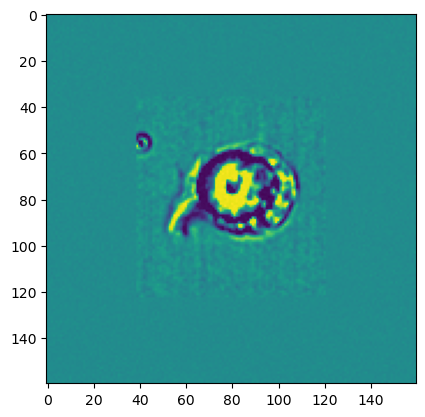

In [23]:
plt.imshow(train_dataset[5][0][0])

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [24]:
import torch.nn as nn
import torch.nn.functional as F

model = PretrainedModel(num_channels= len(channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [25]:
model

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [26]:
model.load_state_dict(torch.load('synapse_formation_DL_fold' + str(main_fold) +'.pth')) 

model.cuda()

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

In [27]:
torch.cuda.empty_cache()

### Model Interpretation

In [28]:
# where to save results
model_name = "resnet18"
dataset_name = "synapse formation"


#### Pixel-Permutation Tests

In [29]:
from time import process_time

In [30]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [31]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [32]:
class_names_targets = [c for c in label_map.keys()]
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.81      0.82      0.81        82
                      B_cell       0.94      1.00      0.97        97
                  Multiplets       0.96      0.84      0.89       104
    No_cell_cell_interaction       0.82      0.94      0.87        99
     Synapses_with_signaling       0.70      0.78      0.74        74
  Synapses_without_signaling       0.78      0.71      0.74        99
                      T_cell       0.91      0.79      0.85       105
T_cell_with_B_cell_fragments       0.92      0.86      0.89       118
       T_cell_with_signaling       0.67      0.81      0.73        57

                    accuracy                           0.84       835
                   macro avg       0.83      0.84      0.83       835
                weighted avg       0.85      0.84      0.84       835



In [33]:
## k ablation

In [ ]:
%%time

t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
shuffle_times_list = [5,10,20,30,40,50,100,200,500,1000]
shuffle_times_results_order = dict()
shuffle_times_results_values = dict()
for shuffle_times in shuffle_times_list:
    min_mean_dif = 1.0
    candidate = 0
    df_all = pd.DataFrame([], columns=class_names_targets)
    for c in range(num_channels):
        f1_score_diff_from_original_per_channel_per_shuffle = []
        transform = test_transform.copy()
        transform.append(ShuffleChannel(channels_to_shuffle=[c]))
        for s in tqdm(range(shuffle_times)):
            dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(transform))
            dataloader = DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)
            y_true = list()
            y_pred = list()
            with torch.no_grad():
                for data in dataloader:
                    inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                    outputs = model(inputs)
                    pred = outputs.argmax(dim=1)
                    for i in range(len(pred)):
                        y_true.append(labels[i].item())
                        y_pred.append(pred[i].item())
                f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
                f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
        mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
        mean_dif = np.mean(mean_along_columns)
        if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
            min_mean_dif = mean_dif
            candidate = selected_channels[c]
        df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
        df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
        df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
        shuffle_times_results_order[shuffle_times] = df_all.T.mean().argsort()
        shuffle_times_results_values[shuffle_times] = df_all.T.mean()

pd.DataFrame(shuffle_times_results_order).to_csv("shuffle_times_results_order" + str(main_fold) + ".csv")
pd.DataFrame(shuffle_times_results_values).to_csv("shuffle_times_results_values" + str(main_fold) + ".csv")

torch.cuda.empty_cache()

 65%|██████▌   | 13/20 [00:16<00:09,  1.33s/it]

In [ ]:
pd.DataFrame(shuffle_times_results_order)

In [ ]:
pd.DataFrame(shuffle_times_results_values)

In [ ]:
1